# Binary oversampling

This notebook presents the general usecase of the ```smote_variants``` package, namely, the oversampling of binary classification datasets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import smote_variants as sv
import imbalanced_databases as imbd
import seaborn as sns

from sklearn.datasets import make_classification

import logging
logging.getLogger('smote_variants').setLevel(logging.CRITICAL)

2022-08-13 15:42:27.272515: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-13 15:42:27.275938: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-13 15:42:27.275947: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Illustrating the imbalanced nature

The imbalanced nature of the ```iris0``` dataset is illustrated by plotting the first two coordinates, the colors of the scatter plot indicating the minority ('olive') and majority ('orange') classes.

In [30]:
X, y= sv.datasets.X_illustration, sv.datasets.y_illustration

AttributeError: module 'smote_variants' has no attribute 'datasets'

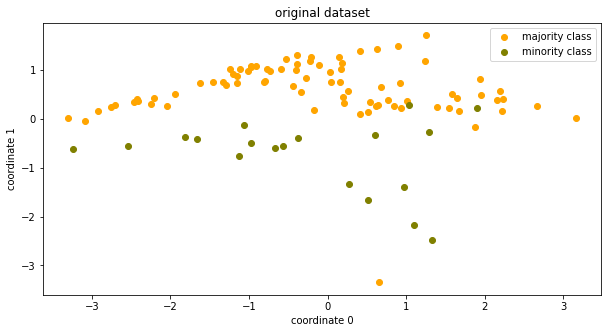

In [3]:
plt.figure(figsize=(10, 5))
plt.scatter(X[y == 0][:,0], X[y == 0][:,1], label='majority class', c='orange')
plt.scatter(X[y == 1][:,0], X[y == 1][:,1], label='minority class', c='olive')
plt.title('original dataset')
plt.xlabel('coordinate 0')
plt.ylabel('coordinate 1')
plt.legend()

In [4]:
# printing the number of samples

print('majority class: %d' % np.sum(y == 0))
print('minority class: %d' % np.sum(y == 1))

majority class: 81
minority class: 19


## Oversampling

The oversampling is carried out by instantiating any oversampler implemented in the package and calling the ```sample``` function.

In [5]:
oversampler= sv.distance_SMOTE()
X_samp, y_samp= oversampler.sample(X, y)

## Illustrating the oversampled dataset

The oversampled dataset is illustrated by printing the number of samples after oversampling. The newly generated samples can be filtered by removing the first ```len(X)``` elements of the oversampled dataset. Note that this filtering works only with *extensive* techniques, namely, with oversamplers which only add samples to the dataset. There are multiple oversamplers which also remove noisy samples, with these oversamplers there is no way to filter newly generated samples.

In [6]:
# printing the number of samples
print('majority class: %d' % np.sum(y_samp == 0))
print('minority class: %d' % np.sum(y_samp == 1))

majority class: 81
minority class: 81


In [7]:
# filtering new samples
X_samp, y_samp= X_samp[len(X):], y_samp[len(y):]

In [8]:
# printing the number of new samples
print('majority new samples: %d' % np.sum(y_samp == 0))
print('minority new samples: %d' % np.sum(y_samp == 1))

majority new samples: 0
minority new samples: 62


## Illustrating all oversampling techniques

In this section, we illustrate the output of all oversampling techniques with default parameters on the ```iris0``` dataset.

In [19]:
oversamplers= sv.get_all_oversamplers()
oversamplers = [sv.PDFOS]

In [20]:
X = X * np.array([100, 200, 150])
X = X + np.array([1000, 2000, 1500])

In [21]:
import matplotlib.cm as cm

In [22]:
oversampler= sv.DBSMOTE(random_state=13)
X_samp, y_samp= oversampler.sample(X, y)

In [29]:
def vector_labeling(X, y, X_samp, y_samp):
    """
    Prepares the data for plotting.

    Args:
        X (np.array): the original vectors
        y (np.array): the original target labels
        X_samp (np.array): the new vectors
        y_samp (np.array): the new target labels
    
    Returns:
        pd.DataFrame: the data prepared for plotting
    """
    original = np.round(np.vstack([X.T, y.T]).T, 4)
    original_unique, original_counts = np.unique(original, return_counts=True, axis=0)
    X_orig, y_orig = original_unique[:, :-1], original_unique[:, -1]

    new = np.round(np.vstack([X_samp.T, y_samp.T]).T, 4)
    new_unique, new_counts = np.unique(new, return_counts=True, axis=0)
    X_new, y_new = new_unique[:, :-1], new_unique[:, -1]

    coords = ['coordinate ' + str(i) for i in range(X_orig.shape[1])]

    orig_pdf = pd.DataFrame(X_orig[:, :2], columns=coords[:2])
    orig_pdf['y'] = y_orig
    orig_pdf['counts'] = original_counts

    new_pdf = pd.DataFrame(X_new[:, :2], columns=coords[:2])
    new_pdf['y'] = y_new
    new_pdf['counts_new'] = new_counts

    orig_pdf['indicator_orig'] = 'original'
    new_pdf['indicator_new'] = 'new'

    result = new_pdf.merge(orig_pdf, how='outer', on=(coords[:2] + ['y']))

    result.loc[(result['counts'] == result['counts_new']) & (result['indicator_orig'] == 'original') & (result['indicator_new'] == 'new'), 'flag'] = 'untouched'
    result.loc[(result['indicator_orig'].isna()) & (result['indicator_new'] == 'new'), 'flag'] = 'new'
    result.loc[(result['indicator_orig'] == 'original') & (result['indicator_new'].isna()), 'flag'] = 'removed'
    result.loc[(result['counts'] != result['counts_new']) & (result['indicator_orig'] == 'original') & (result['indicator_new'] == 'new'), 'flag'] = 'count_changed'

    result['removed_flag'] = result['flag'] == 'removed'
    result['original_flag'] = result['indicator_orig'] == 'original'
    result['resampled_flag'] = result['flag'].isin(['new', 'untouched'])
    result['new_flag'] = result['flag'] == 'new'
    result['untouched_flag'] = result['flag'] == 'untouched'
    result['count_changed_flag'] = result['flag'] == 'count_changed'

    result.loc[result['y'] == 0, 'y'] = 'majority'
    result.loc[result['y'] == 1, 'y'] = 'minority'

    return result

In [24]:
def plot_the_sampling(labeling, title=""):
    """
    Plots the data.

    Args:
        labeling (pd.DataFrame): data prepared for plotting
        title (str): the title
    
    Returns:
        obj: the figure
    """
    
    sns.set(rc = {'figure.figsize':(13, 6)})
    sizes = (100, 200)

    order=['majority', 'minority']

    sns.set_theme(style="white", palette=["orange", "olive"])

    fig, axes = plt.subplots(1, 2)

    ax = sns.scatterplot(
        data=labeling[labeling['original_flag']], x="coordinate 0", y="coordinate 1", hue="y", size="counts", hue_order=order, 
        sizes=sizes, legend=False, ax=axes[0]
    )
    ax.set_title("Original dataset")

    ax = sns.scatterplot(
        data=labeling[labeling['flag'] != 'removed'], x="coordinate 0", y="coordinate 1", hue="y", size="counts_new", hue_order=order, style='flag',
        sizes=sizes, legend='brief', ax=axes[1]
    )
    sns.scatterplot(
        data=labeling[labeling['flag'] == 'removed'], x="coordinate 0", y="coordinate 1", hue="y", hue_order=order, legend=False, alpha=0.3, ax=axes[1]
    )

    sns.move_legend(ax, "upper left", bbox_to_anchor=(1.0, 1.0))

    plt.title(title)

    return fig

In [25]:
labeling = vector_labeling(X, y, X_samp, y_samp)

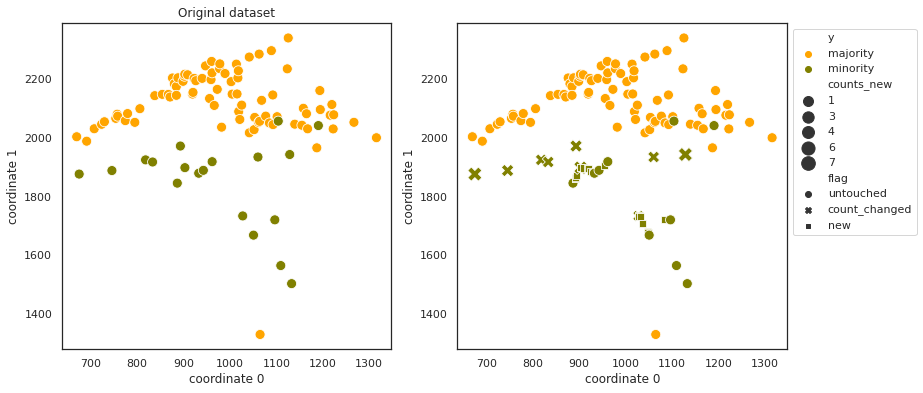

In [27]:
_ = plot_the_sampling(labeling)

In [227]:
labeling.columns

Index(['coordinate 0', 'coordinate 1', 'y', 'counts_new', 'indicator_new',
       'counts', 'indicator_orig', 'flag', 'removed_flag', 'original_flag',
       'resampled_flag'],
      dtype='object')

In [291]:
labeling.groupby(['y', 'flag']).agg({'flag': 'count'})

flag
y        flag               
majority untouched        81
minority count_changed     4
         new              28
         untouched        17

In [299]:
len(y_samp[y_samp == 1])

81

In [136]:


order = ['majority', 'minority']
#order = [0, 1]

In [137]:
result[result['resampled_flag']]

,coordinate 0,coordinate 1,y,counts,indicator_new,indicator_orig,flag,removed_flag,original_flag,resampled_flag
0,-3.300307,0.019600,majority,1,new,original,untouched,False,True,True
1,-3.246622,-0.615995,minority,1,new,original,untouched,False,True,True
2,-3.246622,-0.615995,minority,7,new,NaN,new,False,False,True
3,-3.085525,-0.056315,majority,1,new,original,untouched,False,True,True
4,-2.922497,0.155683,majority,1,new,original,untouched,False,True,True
...,...,...,...,...,...,...,...,...,...,...
125,2.196434,0.568152,majority,1,new,original,untouched,False,True,True
126,2.224050,0.152634,majority,1,new,original,untouched,False,True,True
127,2.235441,0.393591,majority,1,new,original,untouched,False,True,True
128,2.671259,0.265131,majority,1,new,original,untouched,False,True,True


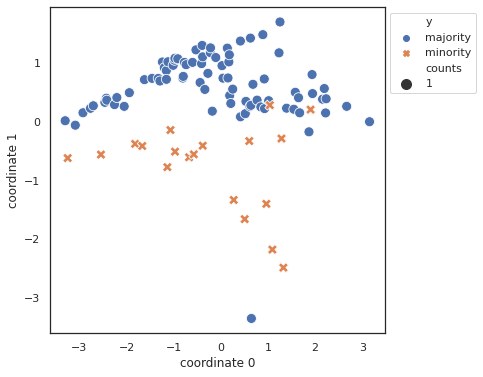

In [187]:
sns.set(rc = {'figure.figsize':(6, 6)})
sizes = (100, 200)

sns.set_theme(style="white", palette="deep")

ax = sns.scatterplot(
    data=result[result['original_flag']], x="coordinate 0", y="coordinate 1", hue="y", size="counts", style="y", hue_order=order, style_order=order,
    sizes=sizes, legend='brief'
)

#plt.legend(loc='upper left')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()

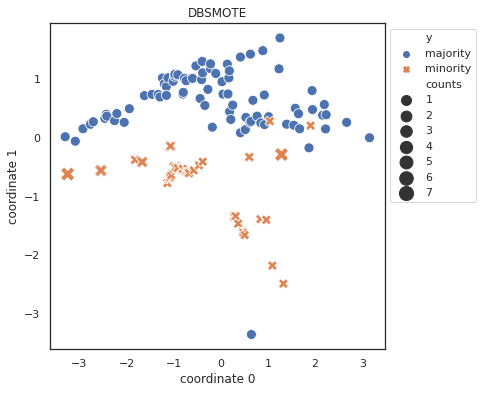

In [188]:
sns.set_theme(style="white", palette="deep")

ax = sns.scatterplot(
    data=result[result['resampled_flag']], x="coordinate 0", y="coordinate 1", hue="y", size="counts", style="y", hue_order=order, style_order=order,
    sizes=sizes, legend='brief'
)
sns.scatterplot(
    data=result[result['removed_flag']], x="coordinate 0", y="coordinate 1", hue="y", size="counts", style="y", hue_order=order, style_order=order,
    sizes=sizes, legend=False, alpha=0.3
)

#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.0, 1.0))

plt.title("DBSMOTE")

plt.show()

In [ ]:
new_pdf['indicator'] = 'new'

In [ ]:
orig_pdf.merge(new_pdf, how='left', on=(coords + ['y', 'counts'])).fillna({'indicator': 'new'})

In [47]:
size = lambda x: (x*30)

for o in oversamplers:
    oversampler= o(random_state=13)
    X_samp, y_samp= oversampler.sample(X, y)
    
    n_1 = np.sum(y_samp == 1)
    range_1 = np.min(X_samp[:,1]), np.max(X_samp[:,1])

    noise_10 = np.random.rand(n_1) * (range_1[1] - range_1[0])/1000
    noise_11 = np.random.rand(n_1) * (range_1[1] - range_1[0])/1000

    plt.figure(figsize=(12, 5))
    ax= plt.subplot(121)
    plt.scatter(X[y == 0][:,0], X[y == 0][:,1], label='majority class', c='orange', marker='o')
    plt.scatter(X[y == 1][:,0], X[y == 1][:,1], label='minority class', c='olive', marker='o')
    plt.title('original')
    plt.xlabel('coordinate 0')
    plt.ylabel('coordinate 1')
    plt.legend()
    
    all_coords = np.vstack([X_samp.T, y_samp]).T
    all_unique, counts = np.unique(all_coords, return_counts=True, axis=0)
    X_samp = all_unique[:, :-1]
    y_samp = all_unique[:, -1]
    y_color = np.array(['orange'] * len(y_samp))
    y_color[y_samp == 1] = 'olive'

    cdict = {0: 'orange', 1: 'olive'}

    ax= plt.subplot(122)
    plt.scatter(X_samp[y_samp == 0][:,0], X_samp[y_samp == 0][:,1], label='majority class', c='orange', marker='o',s=size(counts[y_samp==0]))
    plt.scatter(X_samp[y_samp == 1][:,0], X_samp[y_samp == 1][:,1], label='minority class', c='olive', marker='o',s=size(counts[y_samp==1]))
    #scatter = ax.scatter(X_samp[:,0], X_samp[:,1], c=y_samp, marker='o',s=size(counts))

    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*ax.legend_elements(),
                        loc="upper left", title="Colors")
    ax.add_artist(legend1)

    # produce a legend with a cross section of sizes from the scatter
    handles, labels = ax.legend_elements(prop="sizes", alpha=0.6)
    legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")

    plt.title(oversampler.__class__.__name__)
    plt.xlabel('coordinate 0')
    plt.ylabel('coordinate 1')
    #plt.legend()
    plt.show()

NameError: name 'oversamplers' is not defined